In [4]:
# Load data

In [5]:
name_path = './archive/lfw_allnames.csv'
images_path = './archive/lfw-deepfunneled/lfw-deepfunneled'

In [6]:
import pandas as pd

df_names = pd.read_csv(name_path)
min_faces_per_person = 80
df_names = df_names.loc[df_names["images"] >= min_faces_per_person, :]
names = list(df_names["name"])
names

['Colin_Powell',
 'Donald_Rumsfeld',
 'George_W_Bush',
 'Gerhard_Schroeder',
 'Tony_Blair']

In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np

X = []
Y = []
for name in names:
    dir_path = os.path.join(images_path, name)
    list_images_name = os.listdir(dir_path)
    for image_name in list_images_name:
        image_path = os.path.join(dir_path, image_name)
        img_rgb = plt.imread(image_path)
        X.append(img_rgb)
        Y.append(name)
    print(f"Class: {name}, number of samples: {len(list_images_name)}.")
X = np.asarray(X)
Y = np.asarray(Y)

print(X.shape, Y.shape)

Class: Colin_Powell, number of samples: 236.
Class: Donald_Rumsfeld, number of samples: 121.
Class: George_W_Bush, number of samples: 530.
Class: Gerhard_Schroeder, number of samples: 109.
Class: Tony_Blair, number of samples: 144.
(1140, 250, 250, 3) (1140,)


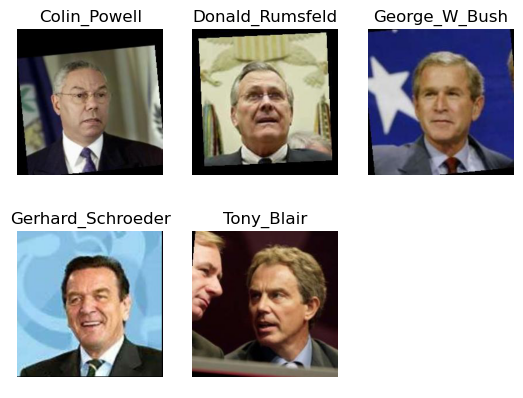

In [8]:
_, indices = np.unique(Y, return_index=True)
columns = 3
rows = (len(indices) // columns) + 1
fig, axs = plt.subplots(frameon=False)
axs.axis('off')

for itr, idx in enumerate(indices):
    # Adds a subplot at the 2nd position 
    fig.add_subplot(rows, columns, itr+1) 
    plt.axis('off')
    plt.title(Y[idx]) 
    plt.imshow(X[idx])
    
plt.show()

In [9]:
from skimage.feature import hog

def create_features(img, show_hog=False):
    # flatten image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = np.array(0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2])
    # get HOG features from greyscale image
    hog_features, hog_image = hog(grey_image, visualize=True, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    if show_hog:
        plt.imshow(hog_image, cmap="gray")
    # combine color and hog features into a single array
    flat_features = np.hstack((color_features, hog_features))
    return flat_features

D:\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [20]:
feature_matrix = []
for x in X:
    feature_matrix.append(create_features(x))

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# get shape of feature matrix
feature_matrix = np.asarray(feature_matrix)
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
bees_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
pca.fit(bees_stand)
X_pca = pca.transform(bees_stand)
print('PCA matrix shape is: ', X_pca.shape)

Feature matrix shape is:  (1140, 201189)
PCA matrix shape is:  (1140, 500)


In [12]:
print('PCA matrix shape is: ', X_pca.shape)
bees_pca = ss.fit_transform(X_pca)
# look at new shape
print('PCA matrix shape is: ', bees_pca.shape)

PCA matrix shape is:  (1140, 500)
PCA matrix shape is:  (1140, 500)


In [13]:
from sklearn.preprocessing import LabelEncoder
# label_encoder object knows  
# how to understand word labels. 
label_encoder = LabelEncoder() 
  
# Encode labels in column 'species'. 
Y = label_encoder.fit_transform(Y) 

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, random_state=42)

In [15]:
from sklearn.svm import SVC

clf = SVC(class_weight='balanced', random_state=42)

In [16]:
from sklearn.model_selection import GridSearchCV

parameters = {'C': [0.1, 1, 10],
             'gamma': [1e-3, 1e-6, 1e-9],
             'kernel': ['rbf', 'linear']}
grid_search = GridSearchCV(clf, parameters, n_jobs=-1, cv=5)

In [17]:
from time import time

t0 = time()
grid_search.fit(X_train, Y_train)
print("grid_search in %0.fs" % (time() - t0))

grid_search in 9s


In [18]:
print(f"The best model is: {grid_search.best_params_}.")
print("The best mean accuracy: ", grid_search.best_score_)

The best model is: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}.
The best mean accuracy:  0.9309941520467836
